In [1]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
## convert one to multiple series
def lag_ahead_series(data, n_in=1, n_out=1, n_vars = 1,dropnan=True):
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for j in range(n_vars):
        for i in range(n_in, 0, -1):
            cols.append(df.iloc[:,j].shift(i))
            names.append('var{}(t-{})'.format(j+1, i))
    
    # forecast sequence (t+1, ... t+n)
    for j in range(n_vars):
        for i in range(0, n_out):
            cols.append(df.iloc[:,j].shift(-i))
            names += [('var{}(t+{})'.format(j+1, i)) ]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## plot dataframe creation
def plot_df(arr, name):
    plot_df = pd.DataFrame()
    i = 0
    for row in arr:
        plot_df.insert(i, "{}_ahead{}".format(name,i), row, True) 
        i += 1
    return plot_df


In [3]:
train = pd.read_csv("train_nocat.csv")
test = pd.read_csv("test_nocat.csv")
train = train.set_index("Unnamed: 0")
test = test.set_index("Unnamed: 0")

In [4]:
#create 12 hours recency effect matrix
ahead_w = lag_ahead_series(train.iloc[:,:8], n_in=0, n_out=49, n_vars = 8, dropnan=True).iloc[:13991,:]
#create 48 housrs ahead energy consumption matrix
ahead_e = lag_ahead_series(train.iloc[:,8:], n_in=0, n_out=49, n_vars = 1, dropnan=True)
ahead_w.shape

(13991, 392)

In [18]:
test_y = lag_ahead_series(test.iloc[:,8:], n_in=0, n_out=49, n_vars = 1, dropnan=True)
test_X = lag_ahead_series(test.iloc[:,:8], n_in=0, n_out=49, n_vars = 8, dropnan=True)
test_X.shape, test_y.shape

((5775, 392), (5775, 49))

###  Scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler

mmscaler = MinMaxScaler() ## will be used later in test set
mmscaler.fit(ahead_w)
mt = mmscaler.transform(ahead_w)


### Feature selection

In [7]:
# Tree based feature selection
from sklearn.tree import ExtraTreeRegressor
from sklearn.feature_selection import SelectFromModel
reg = ExtraTreeRegressor(random_state=0).fit(mt, ahead_e)
model = SelectFromModel(reg, prefit=True)
cols = model.get_support(indices=True)
mt_feature = model.transform(mt)
cols ## the selected features column

array([ 98,  99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 134, 136, 139, 143, 146,
       245, 246, 247, 250, 252, 254, 258, 259, 261, 262, 263, 264, 266,
       269, 271, 272, 274, 280, 282, 288, 290, 326, 331, 344, 345, 347,
       350, 351, 354, 355, 356, 358, 359, 361, 364, 365, 369, 371, 377,
       379, 381, 383, 386, 388])

### TPOT

In [8]:
from tpot import TPOTRegressor
from tpot_mulr import mul_reg_config_dict
from sklearn.model_selection import train_test_split
#import mul_config as mc## import multioutput regressor customized configuration
X = mt_feature
y = ahead_e
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

tpot_reg = TPOTRegressor(generations=20, population_size=50, n_jobs=4, verbosity=2, random_state=321, subsample = 0.75, config_dict=mul_reg_config_dict)
tpot_reg.fit(train_X , train_y)


Generation 1 - Current best internal CV score: -0.005051595554587199
Generation 2 - Current best internal CV score: -0.004339587213693765
Generation 3 - Current best internal CV score: -0.004339587213693765
Generation 4 - Current best internal CV score: -0.004339587213693765
Generation 5 - Current best internal CV score: -0.004339587213693765


TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.2, min_samples_leaf=1, min_samples_split=2, n_estimators=100)


TPOTRegressor(config_dict={'sklearn.ensemble.RandomForestRegressor': {'bootstrap': [True,
                                                                                    False],
                                                                      'max_features': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                                                      'min_samples_leaf': range(1, 21),
                                                                      'min_samples_split': range(2, 21),
                                                                      'n_estimators': [100]},
                           'sklearn.multioutput.RegressorChain': {'estimator': {'xgboos...
              crossover_rate=0.1, cv=5, disable_update_check=False,
              early_stop=None, generations=20, max_eval_time_mins=5,
              max_time_mins=None, memory=None, multi_output=True,

In [20]:
mtest = mmscaler.transform(test_X)
test_x = mtest[:,cols]

In [22]:
#val_X, val_y = train.iloc[500:600,:8], ahead_e.iloc[500:600,:]
yhat = tpot_reg.predict(test_x)

### Result Evaluation

**Mean Square Error**

In [23]:
mean_squared_error(test_y, yhat)

0.006850193042010116

**Mean Absolute Error**

In [24]:
mean_absolute_error(test_y, yhat)

0.060661812519004175

**R2_score**

In [25]:
r2_score(test_y, yhat)

0.681837443619176

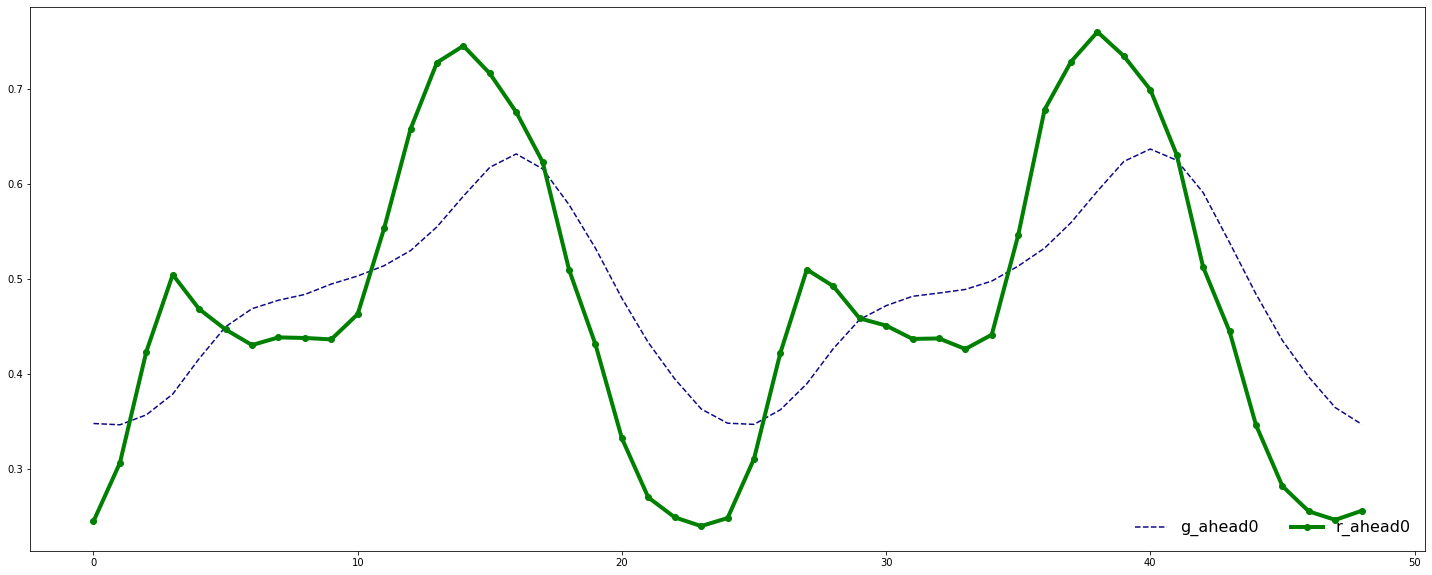

In [31]:
## assignment
real = test_y.to_numpy()
guess = yhat
real = real[4099:4100,:49]
guess = guess[4099:4100,:49]
rpdf = plot_df(real, "r")
gpdf = plot_df(guess, "g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})

plt.show()